Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [13]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [14]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**
По идее при меньшем количестве батчей наш градиентный спуск будет "аккуратнее" и минимум лосс-функции будет найден быстрее + мы будем меньше тратить времени на пересчет коэффициентов, так что по итогу обучение должно быть быстрее при батчах большего размера быстрее. Нооо, оперативная память...

Посмотрим на какую-нибудь картинку:

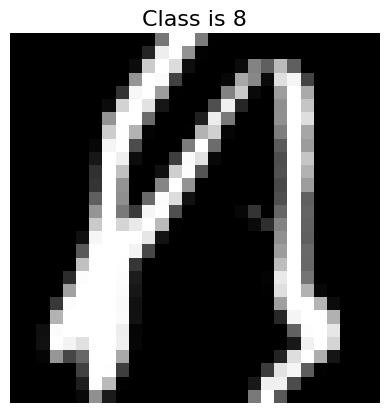

In [15]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





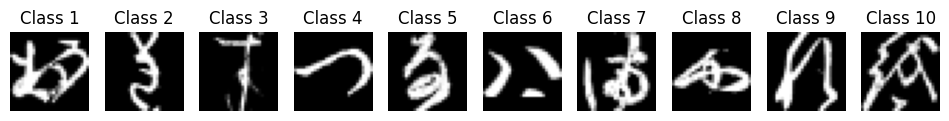

In [21]:
fig, axs = plt.subplots(1, 10, figsize=(12, 6))

for counter in range(10):
  for image, label in trainset:
      if label == counter:
        axs[counter].imshow(image.view(28, 28), cmap="gray")
        axs[counter].set_title(f"Class {counter + 1}")
        axs[counter].axis('off')
        break
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [22]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self, activation = nn.ReLU()):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        logits = x.view(-1, 28*28)
        logits = self.fc1(logits)
        logits = self.activation(logits)
        logits = self.fc2(logits)
        logits = self.activation(logits)
        logits = self.fc3(logits)

        return logits


Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [24]:
weights = 28 * 28 * 256 + 256 * 128 + 128 * 10
bias = 256 + 128 + 10
params = weights + bias

print(f'Wheits number: {weights}\nBias number: {bias}\nParams number: {params}')

Wheits number: 234752
Bias number: 394
Params number: 235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [25]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [26]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [27]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for image, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(image)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch=1 loss=0.9227
Epoch=2 loss=0.4450
Epoch=3 loss=0.3476
Epoch=4 loss=0.2895
Epoch=5 loss=0.2468
Epoch=6 loss=0.2135
Epoch=7 loss=0.1842
Epoch=8 loss=0.1617
Epoch=9 loss=0.1405
Epoch=10 loss=0.1241


In [28]:
accuracy = get_accuracy(fc_net, testloader)
print(f"Accuracy = {accuracy}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy = 0.8811


### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [29]:
mean = torch.mean(trainset.data.to(torch.float32))/torch.max(trainset.data.to(torch.float32))
std = torch.std(trainset.data.to(torch.float32))/torch.max(trainset.data.to(torch.float32))
print(mean, std)


transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [30]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [31]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6792
Epoch=2 loss=0.2980
Epoch=3 loss=0.2181
Epoch=4 loss=0.1702
Epoch=5 loss=0.1360
Epoch=6 loss=0.1105
Epoch=7 loss=0.0912
Epoch=8 loss=0.0740
Epoch=9 loss=0.0612
Epoch=10 loss=0.0492


In [32]:
accuracy = get_accuracy(fc_net, testloader)
print(f"Accuracy = {accuracy}")

Accuracy = 0.8953


Как изменилась `accuracy` после нормализации?

`accuracy` стал повыше

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [39]:
## YOUR CODE HERE
loss_function = nn.CrossEntropyLoss()
lr = 0.001

activation_funcs = (nn.Sigmoid, nn.GELU, nn.Tanh)

In [40]:

n_epochs = 10


for activation_func in activation_funcs:
  print(f"{activation_func.__name__}")
  fc_net = FCNet(activation = activation_func())
  optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
  loss_history = []

  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
      optimizer.zero_grad()
      outputs = fc_net(images)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch = {epoch+1} loss = {loss_history[epoch]:.4f}")
  accuracy = get_accuracy(fc_net, testloader)
  print(f"Accuracy = {accuracy}")


Sigmoid
Epoch=1 loss=1.5617
Epoch=2 loss=0.7549
Epoch=3 loss=0.5463
Epoch=4 loss=0.4462
Epoch=5 loss=0.3768
Epoch=6 loss=0.3223
Epoch=7 loss=0.2795
Epoch=8 loss=0.2440
Epoch=9 loss=0.2146
Epoch=10 loss=0.1896
Accuracy = 0.8555
GELU
Epoch=1 loss=0.6570
Epoch=2 loss=0.2820
Epoch=3 loss=0.2036
Epoch=4 loss=0.1564
Epoch=5 loss=0.1227
Epoch=6 loss=0.0969
Epoch=7 loss=0.0784
Epoch=8 loss=0.0621
Epoch=9 loss=0.0496
Epoch=10 loss=0.0394
Accuracy = 0.9014
Tanh
Epoch=1 loss=0.7845
Epoch=2 loss=0.3855
Epoch=3 loss=0.2590
Epoch=4 loss=0.1850
Epoch=5 loss=0.1368
Epoch=6 loss=0.1032
Epoch=7 loss=0.0768
Epoch=8 loss=0.0578
Epoch=9 loss=0.0428
Epoch=10 loss=0.0305
Accuracy = 0.897


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Лучший `accuracy` дала `GELU`

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [49]:
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizers = (torch.optim.Adagrad, torch.optim.Adam, torch.optim.RMSprop)

In [50]:
n_epochs = 10


for optimizer in optimizers:
  fc_net = FCNet(activation = nn.GELU())
  optimizer = optimizer(fc_net.parameters(), lr=3e-4)
  loss_history = []
  print(f"{optimizer}")

  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
      optimizer.zero_grad()
      outputs = fc_net(images)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

  accuracy = get_accuracy(fc_net, testloader)
  print(f"Accuracy = {accuracy}")

Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    lr: 0.0003
    lr_decay: 0
    maximize: False
    weight_decay: 0
)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch=1 loss=1.3339
Epoch=2 loss=0.8044
Epoch=3 loss=0.6823
Epoch=4 loss=0.6221
Epoch=5 loss=0.5845
Epoch=6 loss=0.5569
Epoch=7 loss=0.5359
Epoch=8 loss=0.5187
Epoch=9 loss=0.5038
Epoch=10 loss=0.4910
Accuracy = 0.7177
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)
Epoch=1 loss=0.6693
Epoch=2 loss=0.2882
Epoch=3 loss=0.2061
Epoch=4 loss=0.1578
Epoch=5 loss=0.1236
Epoch=6 loss=0.0985
Epoch=7 loss=0.0794
Epoch=8 loss=0.0640
Epoch=9 loss=0.0519
Epoch=10 loss=0.0410
Accuracy = 0.9017
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0003
    maximize: False
    momentum: 0
    weight_decay: 0
)
Epoch=1 loss=0.4434
Epoch=2 loss=0.2380
Epoch=3 loss=0.1750
Epoch=4 loss=0.1353
Epoch=5 loss=0.1062
Epoch=6 loss=0.0851
Epoch=7 loss=0.0675
Epoc

Как оптимизатор лучшим себя показал `Adam`

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилось.

In [51]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x

        x[x < 0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [52]:
fc_net = FCNet(activation = CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)


n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

accuracy = get_accuracy(fc_net, testloader)
print(f"Accuracy = {accuracy}")

Epoch=1 loss=0.6895
Epoch=2 loss=0.3122
Epoch=3 loss=0.2296
Epoch=4 loss=0.1790
Epoch=5 loss=0.1434
Epoch=6 loss=0.1156
Epoch=7 loss=0.0949
Epoch=8 loss=0.0786
Epoch=9 loss=0.0634
Epoch=10 loss=0.0531
Accuracy = 0.8979


### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

![alt text](./figures/parrot.png)
![alt text](./figures/whale.png)
![alt text](./figures/violin.png)